In [1]:
import os
import PIL

from os.path import isdir, join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import track from rich
from rich.progress import track

## Centralized learning

In [2]:
# dataset_dir = "datasets/fl_split/2_clients/client_1/train"
dataset_dir = "datasets/COVID-19_Radiography_Dataset/"

classes = [d for d in os.listdir(dataset_dir) if isdir(join(dataset_dir, d))]

print("Classes: ")
for idx, c in enumerate(classes):
    print(f" - {c}")
    if idx >= 10:
        break

Classes: 
 - COVID
 - Lung_Opacity
 - Normal
 - Viral Pneumonia


In [3]:
distribution = {}
file_paths = []
for c in classes:
    class_dir = join(dataset_dir, c)
    files = [f for f in os.listdir(class_dir) if f.endswith(".png")]
    distribution[c] = len(files)
    file_paths.extend([join(class_dir, f) for f in files])

In [4]:
distribution

{'COVID': 3616, 'Lung_Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 1345}

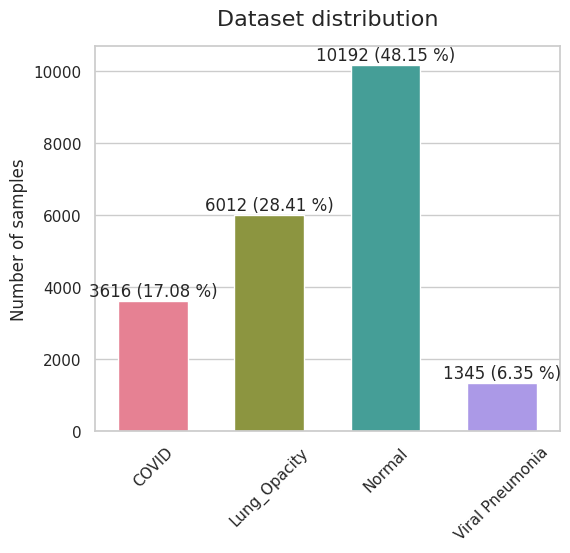

In [5]:
sns.set(style="whitegrid")

colors = sns.color_palette("husl", len(distribution))

plt.figure(figsize=(6, 5))
sns.barplot(x=list(distribution.keys()), y=list(distribution.values()), palette=colors, hue=list(distribution.keys()), width=0.6)
for i, v in enumerate(distribution.values()):
    percentage = ((v / sum(distribution.values())) * 100).__round__(2)
    plt.text(i, v + 10, f"{v} ({percentage} %)", ha="center", va="bottom")
plt.title("Dataset distribution", fontsize=16, pad=15)
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

## Federated learning (multiple clients)

In [25]:
dataset_dir = "datasets/fl_split/8_clients/"

clients = [d for d in os.listdir(dataset_dir) if isdir(join(dataset_dir, d))]
dataset = "val"
classes = [d for d in os.listdir(join(dataset_dir, clients[0], dataset)) if isdir(join(dataset_dir, clients[0], dataset, d))]

print("Classes: ")
for idx, c in enumerate(classes):
    print(f" - {c}")
    if idx >= 10:
        break

Classes: 
 - COVID
 - Lung_Opacity
 - Normal
 - Viral Pneumonia


In [26]:
distribution = {f"client_{idx}": {} for idx in range(1, len(clients) + 1)}
file_paths = {f"client_{idx}": [] for idx in range(1, len(clients) + 1)}
for c in classes:
    # class_dir = join(dataset_dir, c)
    # files = [f for f in os.listdir(class_dir) if f.endswith(".png")]
    # distribution[c] = len(files)
    # file_paths.extend([join(class_dir, f) for f in files])
    for idx, client in enumerate(clients):
        class_dir = join(dataset_dir, client, dataset, c)
        files = [f for f in os.listdir(class_dir) if f.endswith(".png")]
        distribution[f"client_{idx + 1}"][c] = len(files)
        file_paths[f"client_{idx + 1}"].extend([join(class_dir, f) for f in files])

In [27]:
distribution

{'client_1': {'COVID': 46,
  'Lung_Opacity': 76,
  'Normal': 130,
  'Viral Pneumonia': 22},
 'client_2': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16},
 'client_3': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16},
 'client_4': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16},
 'client_5': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16},
 'client_6': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16},
 'client_7': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16},
 'client_8': {'COVID': 45,
  'Lung_Opacity': 75,
  'Normal': 127,
  'Viral Pneumonia': 16}}

In [28]:
dist_ = {k: sum(v.values()) for k, v in distribution.items()}
dist_

{'client_1': 274,
 'client_2': 263,
 'client_3': 263,
 'client_4': 263,
 'client_5': 263,
 'client_6': 263,
 'client_7': 263,
 'client_8': 263}

Text(0.5, 1.0, 'Dataset distribution (train set)')

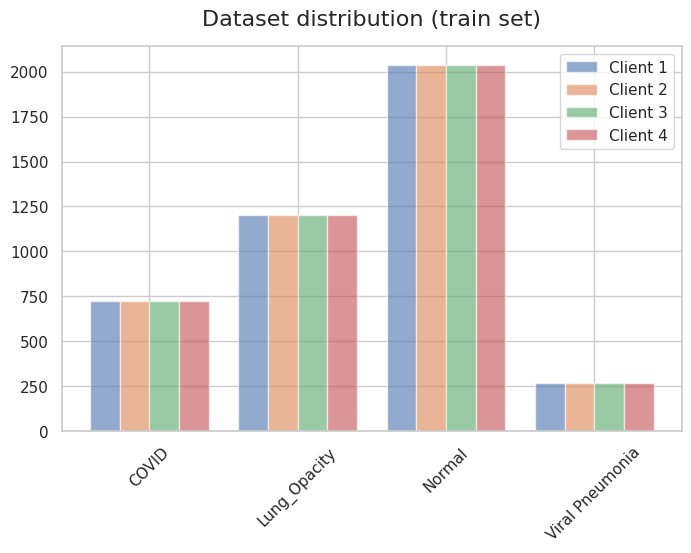

In [9]:
sns.set(style="whitegrid")

# Plotting the distribution of the dataset for each client in the same plot but with different colors
bar_width = 0.20
plt.figure(figsize=(8, 5))
for idx, client in enumerate(clients):
    x_values = np.arange(len(distribution[f"client_{idx + 1}"])) + idx * bar_width
    # sns.barplot(x=x_values, y=list(distribution[f"client_{idx + 1}"].values()), alpha=0.6, label=f"Client {idx + 1}", width=bar_width)
    plt.bar(x=x_values, height=list(distribution[f"client_{idx + 1}"].values()), alpha=0.6, label=f"Client {idx + 1}", width=bar_width)
    # for i, v in enumerate(distribution[f"client_{idx + 1}"].values()):
    #     percentage = ((v / sum(distribution[f"client_{idx + 1}"].values())) * 100).__round__(2)
    #     plt.text(i, v + 10, f"{v} ({percentage} %)", ha="center", va="bottom", rotation=45)
plt.xticks(ticks=np.arange(len(distribution[f"client_{idx + 1}"])) + (len(clients) - 1) * bar_width / 2, labels=list(distribution[f"client_{idx + 1}"].keys()), rotation=45)
plt.legend()
plt.title(f"Dataset distribution ({dataset} set)", fontsize=16, pad=15)

In [18]:
def compute_stats(file_paths):
    ranges = {}
    # for f in file_paths:
    # If file_paths is a dictionary, then we need to flatten it
    if isinstance(file_paths, dict):
        file_paths = [f for files in file_paths.values() for f in files]
    for f in track(file_paths, description="Computing stats..."):
        img = PIL.Image.open(f).convert("L")
        file_name = f.split("\\")[-1]
        # ranges[file_name] = img.getextrema()
        ranges[file_name] = {
            "Intensity range": img.getextrema(),
            "Image size": img.size
        }
    return ranges

Output()

In [ ]:
if not os.path.exists("img_intensities.txt"):
    ranges = compute_stats(file_paths)

    # Save the ranges to a file
    with open("img_intensities.txt", "w") as f:
        for k, v in ranges.items():
            f.write(f"{k}: {v}\n")
else:
    with open("img_intensities.txt", "r") as f:
        ranges = {}
        for line in f.readlines():
            k, v = line.split(":")
            ranges[k] = eval(v)

In [19]:
# def compute_mean_std(ranges):
#     mean = 0
#     std = 0
#     for k, v in ranges.items():
#         mean += sum(v) / 2
#         std += (v[1] - v[0]) / 2
#     mean /= len(ranges)
#     std /= len(ranges)
#     return mean, std

# mean, std = compute_mean_std(ranges)

# print(f"Mean: {mean} | Std: {std}")

In [25]:
sizes = [v["Image size"] for v in ranges.values()]
sizes = np.array(sizes)

print(f"Size of images: {np.unique(sizes, axis=0)}")

Size of images: [[299 299]]


In [23]:
sizes

array([[299, 299],
       [299, 299],
       [299, 299],
       ...,
       [299, 299],
       [299, 299],
       [299, 299]])

In [2]:
# import splitfolders

In [112]:
# splitfolders.ratio(dataset_dir, output="splitted_dataset", seed=42, ratio=(.8, .1, .1))
# splitfolders.fixed(dataset_dir, output="splitted_dataset_oversampled", seed=42, fixed=(22500, )

Copying files: 21165 files [06:43, 52.45 files/s]
